<a href="https://colab.research.google.com/github/WAndalaluna/Clustering-web-app/blob/main/Cluster2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FileUpload(value={}, accept='image/*', description='Upload')

Dropdown(description='Method:', options=('K-Means', 'DBSCAN'), value='K-Means')

FloatSlider(value=0.05, description='Epsilon:', max=0.2, min=0.01, step=0.01)

IntSlider(value=5, description='Min Samples:', max=10, min=1)

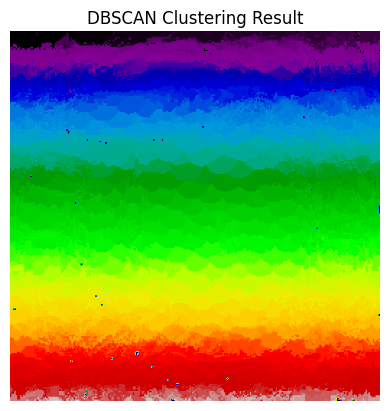

IntSlider(value=5, description='K:', max=10, min=2)

K-Means converged at iteration 17


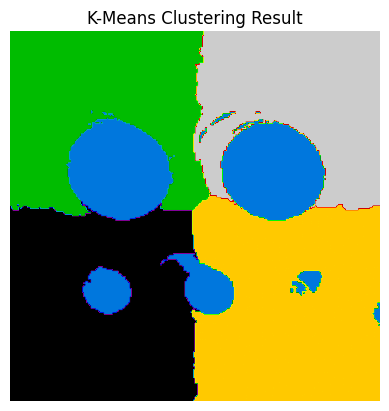

In [1]:
# Importing required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tempfile
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

# Function to load and preprocess image
def load_and_preprocess_image(image):
    # Convert from BGR (OpenCV format) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to a standard size
    image_resized = cv2.resize(image_rgb, (256, 256))
    # Normalize pixel values (range 0-1)
    image_normalized = image_resized / 255.0
    return image_normalized

# Function to extract pixel features (RGB + Spatial Coordinates)
def extract_pixel_features(image):
    h, w, c = image.shape
    # Create arrays for X and Y coordinates
    X_coords = np.repeat(np.arange(w), h).reshape(-1, 1)
    Y_coords = np.tile(np.arange(h), w).reshape(-1, 1)
    # Get RGB values
    RGB_values = image.reshape(-1, 3)
    # Combine color and spatial features
    features = np.hstack((RGB_values, X_coords / w, Y_coords / h))  # Normalize spatial coordinates
    return features

# K-Means clustering algorithm
def k_means(features, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(features, k)
    for i in range(max_iters):
        centroids_old = centroids.copy()
        cluster_labels = assign_clusters(features, centroids)
        centroids = update_centroids(features, cluster_labels, k)
        if np.linalg.norm(centroids - centroids_old) < tol:
            print(f"K-Means converged at iteration {i}")
            break
    return cluster_labels, centroids

def initialize_centroids(features, k):
    indices = np.random.choice(features.shape[0], k, replace=False)
    centroids = features[indices]
    return centroids

def assign_clusters(features, centroids):
    distances = np.linalg.norm(features[:, np.newaxis] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

def update_centroids(features, cluster_labels, k):
    new_centroids = np.array([features[cluster_labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# DBSCAN algorithm
def dbscan(features, eps, min_samples):
    labels = np.full(features.shape[0], -1)  # Initialize all labels as noise (-1)
    cluster_id = 0
    for i in range(features.shape[0]):
        if labels[i] != -1:
            continue  # Already labeled
        neighbors = region_query(features, i, eps)
        if len(neighbors) < min_samples:
            labels[i] = -1  # Remain noise
        else:
            grow_cluster(features, labels, i, neighbors, cluster_id, eps, min_samples)
            cluster_id += 1
    return labels

def region_query(features, idx, eps):
    distances = np.linalg.norm(features - features[idx], axis=1)
    neighbors = np.where(distances < eps)[0]
    return neighbors

def grow_cluster(features, labels, idx, neighbors, cluster_id, eps, min_samples):
    labels[idx] = cluster_id
    i = 0
    while i < len(neighbors):
        point = neighbors[i]
        if labels[point] == -1:
            labels[point] = cluster_id
        elif labels[point] == -2:
            labels[point] = cluster_id
            point_neighbors = region_query(features, point, eps)
            if len(point_neighbors) >= min_samples:
                neighbors = np.concatenate((neighbors, point_neighbors))
        i += 1

# Function to process image with K-Means clustering
def process_image_clustering(image, k=5):
    image_resized = load_and_preprocess_image(image)
    pixel_features = extract_pixel_features(image_resized)
    cluster_labels, centroids = k_means(pixel_features, k)
    clustered_image = cluster_labels.reshape(image_resized.shape[0], image_resized.shape[1])

    plt.imshow(clustered_image, cmap='nipy_spectral')
    plt.title('K-Means Clustering Result')
    plt.axis('off')
    plt.show()

# Function to process image with DBSCAN clustering
def process_dbscan_clustering(image, eps=0.05, min_samples=5):
    image_resized = load_and_preprocess_image(image)
    pixel_features = extract_pixel_features(image_resized)
    cluster_labels = dbscan(pixel_features, eps, min_samples)
    clustered_image = cluster_labels.reshape(image_resized.shape[0], image_resized.shape[1])

    plt.imshow(clustered_image, cmap='nipy_spectral')
    plt.title('DBSCAN Clustering Result')
    plt.axis('off')
    plt.show()

# Image uploader using ipywidgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_button)

# Dropdown to select the method
method_selection = widgets.Dropdown(
    options=['K-Means', 'DBSCAN'],
    description='Method:',
)
display(method_selection)

# Inputs for K-Means or DBSCAN parameters
k_slider = widgets.IntSlider(min=2, max=10, value=5, description='K:')
eps_slider = widgets.FloatSlider(min=0.01, max=0.2, step=0.01, value=0.05, description='Epsilon:')
min_samples_slider = widgets.IntSlider(min=1, max=10, value=5, description='Min Samples:')

# Function to update parameter sliders based on method selected
def on_method_change(change):
    if change['new'] == 'K-Means':
        display(k_slider)
        eps_slider.close()
        min_samples_slider.close()
    else:
        k_slider.close()
        display(eps_slider, min_samples_slider)

method_selection.observe(on_method_change, names='value')

# Function to process image after upload and method selection
def process_image(change):
    if upload_button.value:
        # Extract file content from uploaded data
        uploaded_file = next(iter(upload_button.value.values()))['content']
        image = Image.open(io.BytesIO(uploaded_file))  # Use io.BytesIO to handle the file in-memory

        image_array = np.array(image)  # Convert the image to a numpy array

        if method_selection.value == 'K-Means':
            process_image_clustering(image_array, k=k_slider.value)
        else:
            process_dbscan_clustering(image_array, eps=eps_slider.value, min_samples=min_samples_slider.value)

upload_button.observe(process_image, names='value')